In [1]:
import torch
import torchvision
from torch import nn
import time
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from einops import rearrange
from torchvision import datasets, transforms
from torch.utils.data import Dataset, SubsetRandomSampler, DataLoader

import argparse
import sys
sys.argv = ['run.py']

import h5py
import copy

import numpy as np
import matplotlib.pylab as plt

In [2]:
parser = argparse.ArgumentParser(description='NN heisenberg four phases map') 

parser.add_argument('--batch-size', type=int, default=100, metavar='N',help='input batch size for training (default: 100)')

parser.add_argument('--epochs', type=int, default=100, metavar='N',help='number of epochs to train (default: 100)')

parser.add_argument('--no-cuda', action='store_true', default=False,help='enables CUDA training')

parser.add_argument('--imgage-size', type=int, default=20,help='input image size')

parser.add_argument('--imgage-patch', type=int, default=4,help='segmentation image patch')

parser.add_argument('--channels', type=int, default=2, help='_')

parser.add_argument('--num-class', type=int, default=4,help='num class')

parser.add_argument('--mlp-dim', type=int, default=100, help='_')

parser.add_argument('--num_token',type=int, default=96, help='_')

parser.add_argument('--dropout-rate', type=int, default=0.2, help='_')

parser.add_argument('--learning-rate', type=int, default=1e-4, help='_')

args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")

In [3]:
#Temperature
T = np.linspace(1,35,35)
#载入数据
data_whole=[]
M_raw_all=[]

for i in [1,2,3,5,7,9]:
    
    with h5py.File('four_phases_data/124_MT_20size_{}T_jiangede.hdf5'.format(i), 'r') as f:
        M_raw=[]
        data=[]

        for i in np.arange(1,len(T)+1):   
            
            dataset=f[str(i)+'.0K']
        
            data.append(dataset[:])

            M_raw.append(dataset[:].mean(axis=(0,2,3)).sum())


    M_raw=np.array(M_raw)
    M_raw_all.append(M_raw)
    data_whole.append(data)
data_whole=np.array(data_whole)
# data_whole=data_whole.reshape(-1,2,10,10)


The_shape=data_whole.shape
print(The_shape)

data_whole=data_whole.reshape(-1, args.channels*args.imgage_size*args.imgage_size)

Tc=19

Phase_label_1=[]

[Phase_label_1.append(0) if i<Tc else Phase_label_1.append(3) for _ in range(2) for i in range(len(T)) for j in range(The_shape[2])]

print(len(Phase_label_1))

Tc=22

Phase_label_2=[]

[Phase_label_2.append(1) if i<Tc else Phase_label_2.append(3) for _ in range(2) for i in range(len(T)) for j in range(The_shape[2])]

print(len(Phase_label_2))


Tc=26

Phase_label_3=[]

[Phase_label_3.append(2) if i<Tc else Phase_label_3.append(3) for _ in range(2) for i in range(len(T)) for j in range(The_shape[2])]

print(len(Phase_label_3))

Phase_label=Phase_label_1+Phase_label_2+Phase_label_3
Phase_label=np.array(Phase_label)
print(Phase_label.shape)


data_whole=torch.tensor((data_whole+1)/2).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

print(data_whole.shape)
print(Phase_label.shape)

#整合数据与标签
data_all=[]
for i in range(int(The_shape[0]*The_shape[1]*The_shape[2])):#
    data_all.append([data_whole[i], Phase_label[i]])

print(len(data_all))

(6, 35, 500, 2, 20, 20)
35000
35000
35000
(105000,)
torch.Size([105000, 800])
torch.Size([105000])
105000


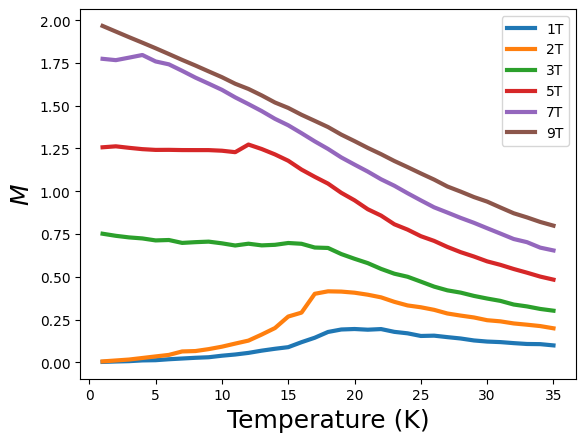

In [5]:
for i, j in zip(range(len(M_raw_all)),[1,2,3,5,7,9]) :

    plt.plot(T,M_raw_all[i],label='{}T'.format(j),lw=3)

plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel(r'$M$', fontsize=18)

# plt.text(25,0.05,'Training dataset',fontsize=16)
# plt.text(5,0.30,'Training dataset',fontsize=16)

plt.legend()
plt.show()

In [7]:
#Temperature
T = np.linspace(1,35,35)
#载入数据
data_whole=[]
M_raw_all_test=[]

for i in [1.5, 4, 8]:
    
    with h5py.File('four_phases_data/124_MT_20size_{}T_jiangede.hdf5'.format(i), 'r') as f:
        M_raw=[]
        data=[]

        for i in np.arange(1,len(T)+1):   
            
            dataset=f[str(i)+'.0K']
        
            data.append(dataset[:])

            M_raw.append(dataset[:].mean(axis=(0,2,3)).sum())


    M_raw=np.array(M_raw)
    M_raw_all_test.append(M_raw)
    data_whole.append(data)
data_whole=np.array(data_whole)

The_shape=data_whole.shape
print(The_shape)

data_whole=data_whole.reshape(-1, args.channels*args.imgage_size*args.imgage_size)

Tc=19
Phase_label_1=[]
[Phase_label_1.append(0) if i<Tc else Phase_label_1.append(3)  for i in range(len(T)) for j in range(The_shape[2])]


Tc=22
Phase_label_2=[]
[Phase_label_2.append(1) if i<Tc else Phase_label_2.append(3)  for i in range(len(T)) for j in range(The_shape[2])]


Tc=26
Phase_label_3=[]
[Phase_label_3.append(2) if i<Tc else Phase_label_3.append(3)  for i in range(len(T)) for j in range(The_shape[2])]

Phase_label=Phase_label_1+Phase_label_2+Phase_label_3
Phase_label=np.array(Phase_label)
print(Phase_label.shape)


data_whole=torch.tensor((data_whole+1)/2).to(torch.float32)
Phase_label=torch.tensor(Phase_label).to(torch.long)

print(data_whole.shape)
print(Phase_label.shape)

#整合数据与标签
data_all_test=[]
for i in range(int(The_shape[0]*The_shape[1]*The_shape[2])):#
    data_all_test.append([data_whole[i], Phase_label[i]])

print(len(data_all_test))



(3, 35, 500, 2, 20, 20)
(52500,)
torch.Size([52500, 800])
torch.Size([52500])
52500


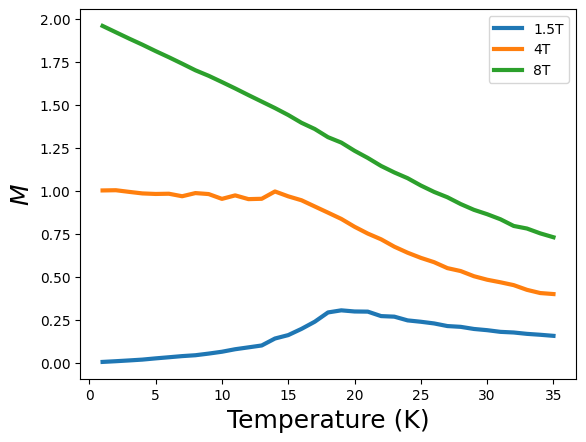

In [8]:
for i, j in zip(range(len(M_raw_all_test)),[1.5, 4, 8]) :

    plt.plot(T,M_raw_all_test[i],label='{}T'.format(j),lw=3)

plt.xlabel('Temperature (K)', fontsize=18)
plt.ylabel(r'$M$', fontsize=18)


plt.legend()
plt.show()

In [9]:
class Heisenberg_dataset:
    def __init__(self, x_list):
        """ initialize the class instance
        Args:
            x_list: data with list type
        Returns:
            None
        """
        if not isinstance(x_list, list):
            raise ValueError("input x_list is not a list type")
        self.data = x_list
        print("intialize success")
    
    def __getitem__(self, idx):
        # print("__getitem__ is called")
        return self.data[idx]
    
    def __len__(self):
        # print("__len__ is called")
        return len(self.data)

data_train = Heisenberg_dataset(data_all)
data_test = Heisenberg_dataset(data_all_test)

train_loader = DataLoader(data_train, batch_size = args.batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size = args.batch_size, shuffle=True )


intialize success
intialize success


In [18]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self, v_dim=200,h_dim=500, class_num=4,dropout=0.1, depth=2):
        # initialise parent pytorch class
        super().__init__()
        
        layers = [nn.Linear(v_dim, h_dim),  nn.BatchNorm1d(h_dim), nn.ReLU(),nn.Dropout(p=dropout),]

        for _ in range(depth):
            layers.append(nn.Linear(h_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))

            layers.append(nn.ReLU())
            # layers.append(nn.LayerNorm(h_dim))
            layers.append(nn.Dropout(p=dropout))

        layers.append(nn.Linear(h_dim, class_num))

        # self.model = nn.Sequential(*layers)
        self.model = nn.ModuleList(layers)
    
    def forward(self, x):

        # # simply run model
        # return self.model(x)

        for layer in self.model:
            x = layer(x)

        return x

    

def Train_model(model, optimizer, data_loader, loss_history,epoch):
    model.train()
    total_samples = len(data_loader)*data_loader.batch_size#len(data_loader.dataset)

    The_loss=0

    for data, target in data_loader:

        
        optimizer.zero_grad()
        data=data.to(device)
        target=target.to(device)

        loss_f = nn.CrossEntropyLoss()
        loss = loss_f(model.forward(data), target)

        The_loss+=loss.detach().item()

        loss.backward()
        optimizer.step()


    loss_history.append(The_loss/len(data_loader))#loss.item()

    if epoch % 10==0 or epoch<=5:
        print('Epoch {}: Average train loss : {:.5f}'.format(epoch,The_loss/len(data_loader)))

def evaluate(model, data_loader, loss_history,Accuracy_rate,epoch):
    model.eval()

    total_samples = len(data_loader)*data_loader.batch_size#len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        
        for data, target in data_loader:
            data=data.to(device)
            target=target.to(device)
            ###
            # output = F.log_softmax(model(data), dim=1)
            # loss = F.nll_loss(output, target, reduction='sum')
            loss_f = nn.CrossEntropyLoss()
            loss = loss_f(model(data),target)

            # _, pred = torch.max(output, dim=0)#

            total_loss += loss.item()
            # correct_samples += pred.eq(target).sum()
            ###
            output_f=nn.Softmax(dim=-1)
            predicted = output_f(model.forward(data)).argmax(dim=-1)

            # total += target.size(0)
            correct_samples += predicted.eq(target).sum().item()


    avg_loss = total_loss / len(data_loader)#total_samples
    loss_history.append(avg_loss)
    Accuracy = (100.0 * correct_samples / total_samples)
    Accuracy_rate.append(Accuracy)

    if epoch % 10 ==0 or epoch<=5:

        print('Epoch {}: '.format(epoch)+'Average test loss: ' + '{:.5f}'.format(avg_loss) +
            '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
            '{:5}'.format(total_samples) + ' (' +
            '{:4.2f}'.format(Accuracy) + '%)\n')


In [19]:
%%time


model_D = Discriminator(v_dim=args.channels*args.imgage_size**2, h_dim=args.mlp_dim, class_num=args.num_class,dropout=0.3,depth=1)#args.dropout_rate

model_D.to(device)
optimizer = optim.Adam(model_D.parameters(), lr=args.learning_rate)

train_loss_history, test_loss_history, Accuracy_rate = [], [], []
for epoch in range(1, args.epochs + 1):#5
    # print('Epoch:', epoch)
    Train_model(model_D, optimizer, train_loader, train_loss_history,epoch)
    evaluate(model_D, test_loader, test_loss_history,Accuracy_rate,epoch)

Epoch 1: Average train loss : 0.59195
Epoch 1: Average test loss: 0.76646  Accuracy:37169/52500 (70.80%)

Epoch 2: Average train loss : 0.47086
Epoch 2: Average test loss: 0.41143  Accuracy:44904/52500 (85.53%)

Epoch 3: Average train loss : 0.41634
Epoch 3: Average test loss: 0.35508  Accuracy:45284/52500 (86.26%)

Epoch 4: Average train loss : 0.37608
Epoch 4: Average test loss: 0.33613  Accuracy:45718/52500 (87.08%)

Epoch 5: Average train loss : 0.34809
Epoch 5: Average test loss: 0.35320  Accuracy:44306/52500 (84.39%)

Epoch 10: Average train loss : 0.26275
Epoch 10: Average test loss: 0.33052  Accuracy:45219/52500 (86.13%)

Epoch 20: Average train loss : 0.18773
Epoch 20: Average test loss: 0.35074  Accuracy:44836/52500 (85.40%)

Epoch 30: Average train loss : 0.15019
Epoch 30: Average test loss: 0.34689  Accuracy:45448/52500 (86.57%)

Epoch 40: Average train loss : 0.12273
Epoch 40: Average test loss: 0.40477  Accuracy:45694/52500 (87.04%)

Epoch 50: Average train loss : 0.10924

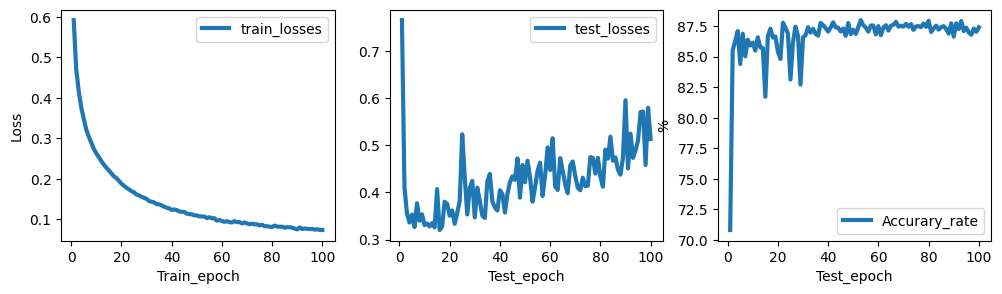

In [20]:
fig=plt.figure(figsize=(12,3))

ax1=plt.subplot(131)
ax1.plot(np.arange(1,len(train_loss_history)+1),train_loss_history, linewidth=3, linestyle='-', label='train_losses')
ax1.set_xlabel('Train_epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2=plt.subplot(132)
ax2.plot(np.arange(1,len(test_loss_history)+1),test_loss_history, linewidth=3, linestyle='-', label='test_losses')
ax2.set_xlabel('Test_epoch')
ax2.legend()

ax3=plt.subplot(133)
ax3.plot(np.arange(1,len(Accuracy_rate)+1),Accuracy_rate, linewidth=3, linestyle='-', label='Accurary_rate')
ax3.set_xlabel('Test_epoch')
ax3.set_ylabel('%')
ax3.legend()

plt.show()